## Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [51]:
torch.manual_seed(42)
device = 'cuda:0'

In [3]:
torch.cuda.is_available()

True

## Data

In [3]:
# path where data will be stored
DATA_PATH = r'D:\Users\amira\Documents\projects\face-recognition\data'

In [4]:
IMG_SIZE = 224

transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

Датасет выдаёт пару изображений и метку
- 1 - на фото один и тот же человек
- 0 - на фото разные люди

In [5]:
lfw_pairs_train = torchvision.datasets.LFWPairs(root = DATA_PATH, split = 'train', image_set = 'funneled', transform = transform, download = True)

Files already downloaded and verified


## Helper Functions

In [6]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

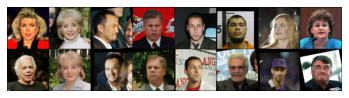

[0 1 1 1 1 0 0 0]


In [7]:
vis_dataloader = DataLoader(lfw_pairs_train,
                            shuffle=True,
                            num_workers=2,
                            batch_size=8)

example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

## Contrastive Loss

In [7]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean(label * torch.pow(euclidean_distance, 2) +
                                    (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

## Simple Siamese Network (IMG_SIZE = 100)

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

### Training

In [ ]:
train_dataloader = DataLoader(lfw_pairs_train,
                        shuffle=True,
                        num_workers=2,
                        batch_size=32)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.005)

Epoch number 0
 Current loss 2.24453067779541

Epoch number 0
 Current loss 1.4894664287567139

Epoch number 0
 Current loss 1.4912469387054443

Epoch number 0
 Current loss 1.2865924835205078

Epoch number 1
 Current loss 1.250867486000061

Epoch number 1
 Current loss 1.336142897605896

Epoch number 1
 Current loss 1.1627795696258545

Epoch number 1
 Current loss 1.2204841375350952

Epoch number 2
 Current loss 1.3213530778884888

Epoch number 2
 Current loss 1.2968401908874512

Epoch number 2
 Current loss 1.282132863998413

Epoch number 2
 Current loss 1.4666467905044556

Epoch number 3
 Current loss 1.369583010673523

Epoch number 3
 Current loss 1.3167380094528198

Epoch number 3
 Current loss 1.4542280435562134

Epoch number 3
 Current loss 1.2224030494689941

Epoch number 4
 Current loss 1.192530632019043

Epoch number 4
 Current loss 1.1129484176635742

Epoch number 4
 Current loss 1.164567470550537

Epoch number 4
 Current loss 1.2101125717163086

Epoch number 5
 Current loss

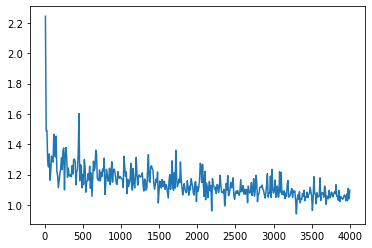

In [16]:
NUM_EPOCHS = 100

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(NUM_EPOCHS):
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        
        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

### Validation

In [17]:
lfw_pairs_test = torchvision.datasets.LFWPairs(root = r'D:\Users\amira\Documents\projects\face-recognition\data', split = 'test', image_set = 'funneled', transform=transform, download = True)

Files already downloaded and verified


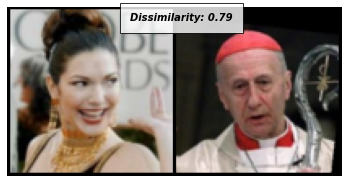

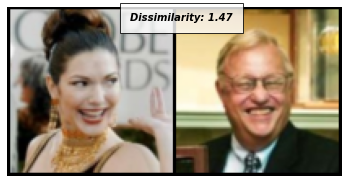

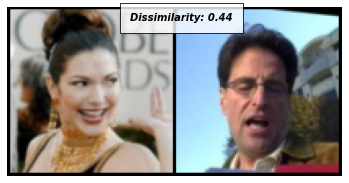

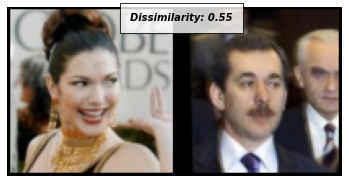

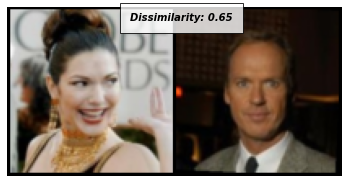

In [18]:
test_dataloader = DataLoader(lfw_pairs_test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

Как можно заметить, на данном этапе модель практически не справляется со своей задачей. Попробуем увеличить размер изображения до 224x224, и добавить слоёв.

## Simple CNN with more layers (IMG_SIZE = 224)

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=4,stride=2), # 96*111*111
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2), #96*55*55
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1), # 256*51*51
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2), # 256*25*25

            nn.Conv2d(256, 384, kernel_size=3,stride=1), # 384*23*23
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2), # 384*11*11

            nn.Conv2d(384, 500, kernel_size=3,stride=2), # 500*5*5
            nn.ReLU(inplace=True),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(12500, 4000),
            nn.ReLU(inplace=True),

            nn.Linear(4000, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        output = self.cnn1(x)
        #print(output.shape)
        output = output.view(output.size()[0], -1)
        #print(output.shape)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [12]:
# Load the training dataset
train_dataloader = DataLoader(lfw_pairs_train,
                        shuffle=True,
                        batch_size=32)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

Epoch number 0
 Current loss 2.1243276596069336

Epoch number 0
 Current loss 2.3351473808288574

Epoch number 0
 Current loss 1.518886685371399

Epoch number 0
 Current loss 1.3336660861968994

Epoch number 0
 Current loss 1.2687360048294067

Epoch number 0
 Current loss 1.2533515691757202

Epoch number 0
 Current loss 1.0905325412750244

Epoch number 1
 Current loss 1.6652213335037231

Epoch number 1
 Current loss 1.0368293523788452

Epoch number 1
 Current loss 1.2082030773162842

Epoch number 1
 Current loss 1.265764594078064

Epoch number 1
 Current loss 1.2743043899536133

Epoch number 1
 Current loss 1.4914965629577637

Epoch number 1
 Current loss 1.6313965320587158

Epoch number 2
 Current loss 1.0692137479782104

Epoch number 2
 Current loss 1.2266921997070312

Epoch number 2
 Current loss 1.2604899406433105

Epoch number 2
 Current loss 1.1798871755599976

Epoch number 2
 Current loss 1.389216661453247

Epoch number 2
 Current loss 1.2632824182510376

Epoch number 2
 Current

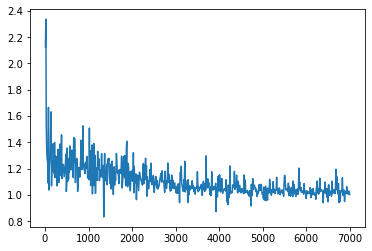

In [13]:
NUM_EPOCHS = 100

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(NUM_EPOCHS):
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        
        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

### Validation

In [14]:
lfw_pairs_test = torchvision.datasets.LFWPairs(root = DATA_PATH, split = 'test', image_set = 'funneled', transform=transform, download = True)

Files already downloaded and verified


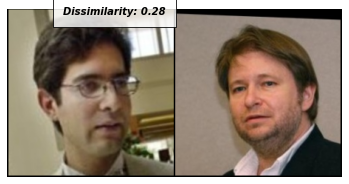

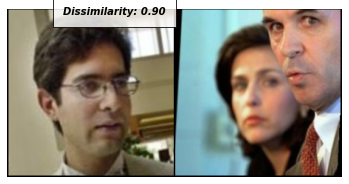

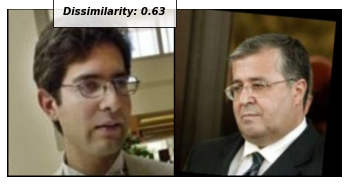

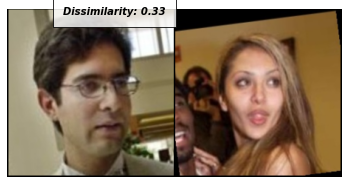

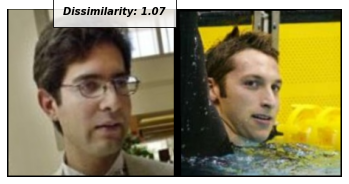

In [15]:
test_dataloader = DataLoader(lfw_pairs_test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## ResNet50 as Base Net

In [9]:
class SiameseNetwork(nn.Module):    
    def __init__(self, base_net, emb_dim, feat_dim=None):
        super(SiameseNetwork, self).__init__()
        self.base_net = base_net
        
        try:
            in_dim = base_net.fc.out_features
        except NameError as e:
            if feat_dim is not None:
                in_dim = feat_dim
            else:
                raise Exception("Neither does the base_net hase fc layer nor in_dim is specificed")
        self.dense = nn.Linear(in_dim, emb_dim)
        

    def forward_once(self, x):
        output = self.base_net(x)
        #print(output.shape)
        # output = output.view(output.size()[0], -1)
        #print(output.shape)
        output = self.dense(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)

        output2 = self.forward_once(input2)

        return output1, output2


In [10]:
from torchvision.models import resnet50

resnet_50 = resnet50(pretrained=True)

In [11]:
train_dataloader = DataLoader(lfw_pairs_train,
                        shuffle=True,
                        batch_size=16)

net = SiameseNetwork(base_net=resnet_50, emb_dim=128, feat_dim=512).cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.005)

Epoch number 0
 Current loss 79.4833984375

Epoch number 0
 Current loss 4.737780570983887

Epoch number 0
 Current loss 1.7115788459777832

Epoch number 0
 Current loss 1.221269965171814

Epoch number 0
 Current loss 1.2159979343414307

Epoch number 0
 Current loss 1.0310819149017334

Epoch number 0
 Current loss 1.2225972414016724

Epoch number 0
 Current loss 1.2901675701141357

Epoch number 0
 Current loss 1.2556238174438477

Epoch number 0
 Current loss 1.4255344867706299

Epoch number 0
 Current loss 1.0767418146133423

Epoch number 0
 Current loss 1.1498489379882812

Epoch number 0
 Current loss 1.3342375755310059

Epoch number 0
 Current loss 1.0600889921188354

Epoch number 1
 Current loss 1.2803270816802979

Epoch number 1
 Current loss 1.1260855197906494

Epoch number 1
 Current loss 1.196163296699524

Epoch number 1
 Current loss 0.8681753873825073

Epoch number 1
 Current loss 1.126320719718933

Epoch number 1
 Current loss 1.2352434396743774

Epoch number 1
 Current loss 

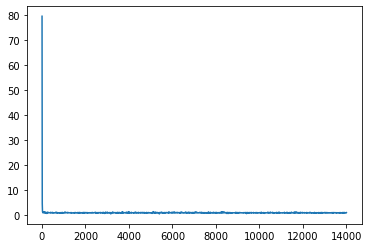

In [12]:
NUM_EPOCHS = 100

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(NUM_EPOCHS):
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        
        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

In [ ]:
SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'

In [18]:
torch.save(net.state_dict(), os.path.join(SAVE_PATH, 'resnet50_100'))

### Validation

In [ ]:
net = SiameseNetwork(base_net=resnet_50, emb_dim=128, feat_dim=512).cuda()
net.load_state_dict(torch.load(os.path.join(SAVE_PATH, 'resnet50_100'))
net.eval()

In [65]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

In [66]:
lfw_pairs_test = torchvision.datasets.LFWPairs(root = r'D:\Users\amira\Documents\projects\face-recognition\data', split = 'test', transform=transform, image_set = 'funneled', download = True)

Files already downloaded and verified


In [67]:
test_dataloader = DataLoader(lfw_pairs_test, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


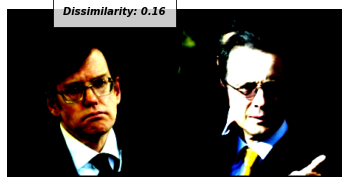

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


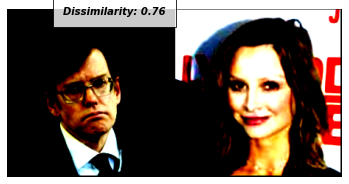

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


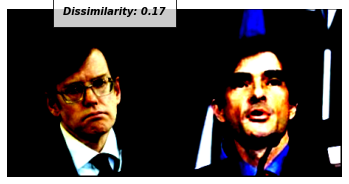

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


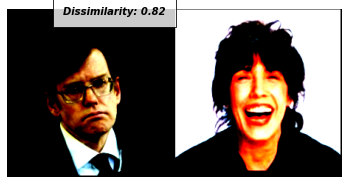

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


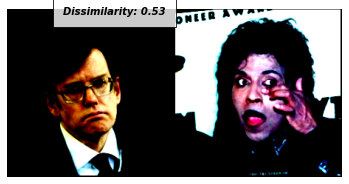

In [21]:
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')